In [4]:
import pandas as pd

# ===========================
# 1) Cargar archivo
# ===========================
path = r"C:\Users\lucia\Desktop\Uni\5 cuatri\Inv II\archivos\Analisis.xlsx"
df = pd.read_excel(path, header=None)

# ===========================
# 2) Buscar filas donde aparece "Tiempo"
# ===========================
tablas = []
filas_tiempo = df.index[df.apply(lambda row: row.astype(str).str.contains("Tiempo").any(), axis=1)].tolist()

print("Tablas detectadas en filas:", filas_tiempo)

# ===========================
# 3) Extraer cada tabla automáticamente
# ===========================
for fila in filas_tiempo:
    # detectar última fila de la tabla (hasta fila vacía)
    fin = fila + 1
    while fin < len(df) and not df.iloc[fin].isna().all():
        fin += 1

    bloque = df.iloc[fila:fin].reset_index(drop=True)

    # La primera fila del bloque tiene los nombres de columnas
    bloque.columns = bloque.iloc[0]
    bloque = bloque[1:].reset_index(drop=True)

    # Convertir números correctamente
    for c in bloque.columns:
        try:
            bloque[c] = pd.to_numeric(bloque[c], errors="coerce")
        except:
            pass

    tablas.append(bloque)

# ===========================
# 4) Mostrar resumen
# ===========================
print(f"Se detectaron {len(tablas)} tablas.")
for i, t in enumerate(tablas):
    print(f"\n--- TABLA {i+1} ---")
    print(t.head())


Tablas detectadas en filas: [3, 31, 59, 86]
Se detectaron 4 tablas.

--- TABLA 1 ---
0  NaN  Tiempo      A1         errA1      A3     errA3      A5     errA5  \
0  NaN       0  0.0000  0.000000e+00  0.0000  0.000000  0.0000  0.000000   
1  NaN      23  0.0005  7.071068e-04 -0.0005  0.002121 -0.0005  0.000707   
2  NaN      42  0.0005  7.071068e-04  0.0025  0.000707 -0.0020  0.004243   
3  NaN      61  0.0000  0.000000e+00  0.0020  0.000000 -0.0015  0.003536   
4  NaN      81  0.0010  9.813078e-18  0.0035  0.000707 -0.0010  0.004243   

0      A7     errA7  ...     B1         errB1      B3         errB3      B5  \
0  0.0000  0.000000  ...  0.000  0.000000e+00  0.0000  0.000000e+00  0.0000   
1 -0.0010  0.000000  ...  0.000  0.000000e+00  0.0045  3.535534e-03  0.0020   
2 -0.0005  0.000707  ...  0.000  0.000000e+00  0.0055  3.535534e-03  0.0015   
3  0.0000  0.000000  ...  0.000  0.000000e+00  0.0035  7.071068e-04  0.0030   
4  0.0000  0.000000  ...  0.001  1.962616e-17  0.0030  9.813078

# Plot Malo


In [4]:
import matplotlib.pyplot as plt

def plot_letra(tabla, letra):
    """
    Grafica todos los índices 1,3,5,7,9,11 para una letra dada.
    tabla = dataframe (uno de los bloques)
    letra = "A", "B", ..., "H"
    """
    tiempos = tabla["Tiempo"]

    indices = [1, 3, 5, 7, 9, 11]

    plt.figure(figsize=(8,5))

    for i in indices:
        mean_col = f"{letra}{i}"
        err_col  = f"err{letra}{i}"

        if mean_col in tabla.columns:
            plt.errorbar(
                tiempos,
                tabla[mean_col],
                yerr=tabla[err_col],
                fmt='o-',
                capsize=4,
                label=f"{mean_col}"
            )

    plt.xlabel("Tiempo (s)")
    plt.ylabel("Mean")
    plt.title(f"Evolución temporal: {letra}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


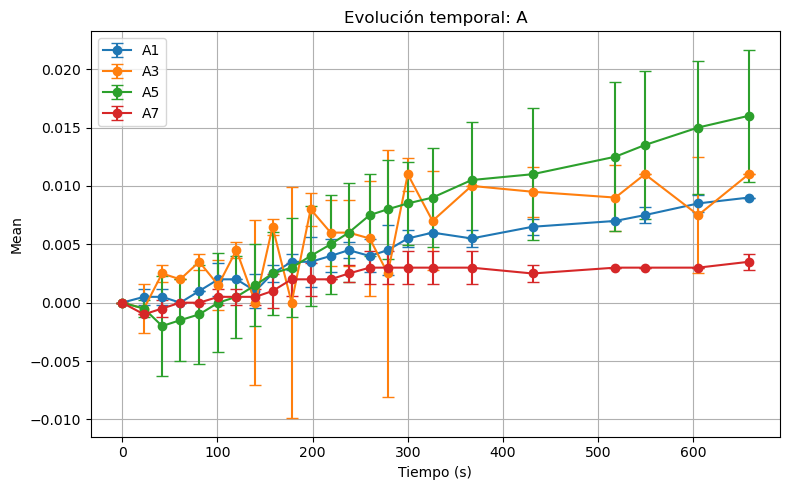

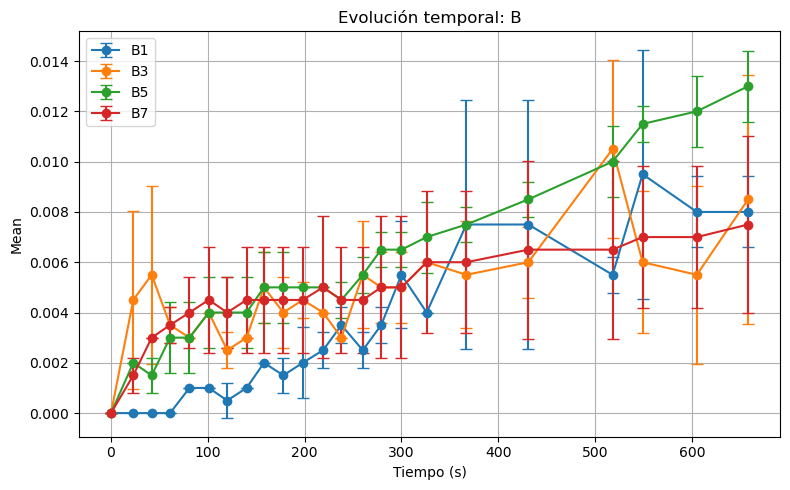

In [5]:
plot_letra(tablas[0], "A")
plot_letra(tablas[0], "B")


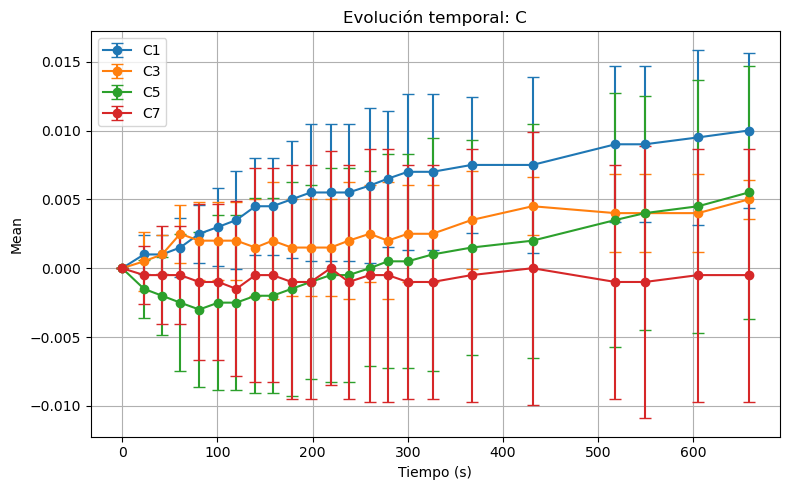

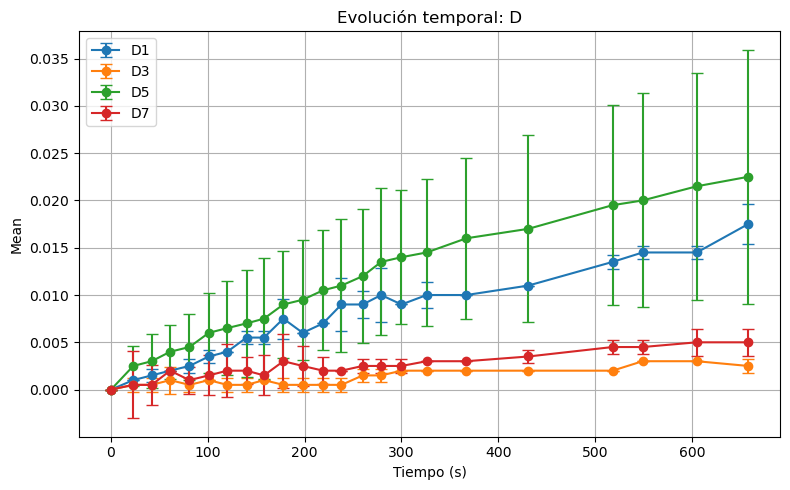

In [6]:
plot_letra(tablas[1], "C")
plot_letra(tablas[1], "D")


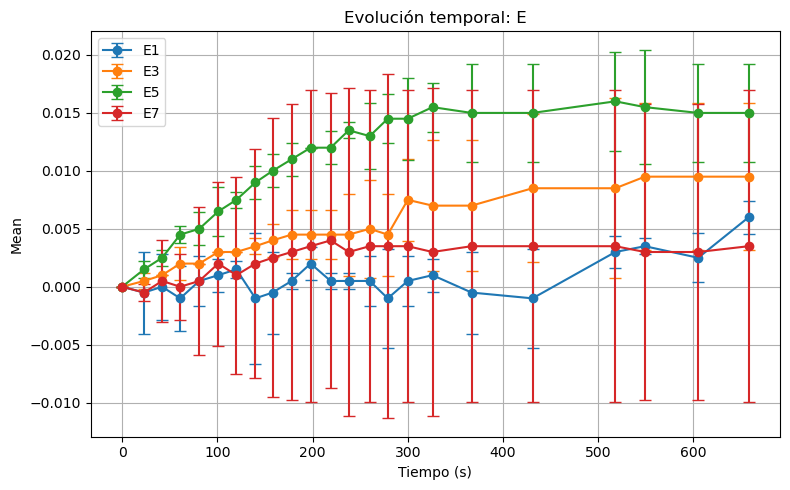

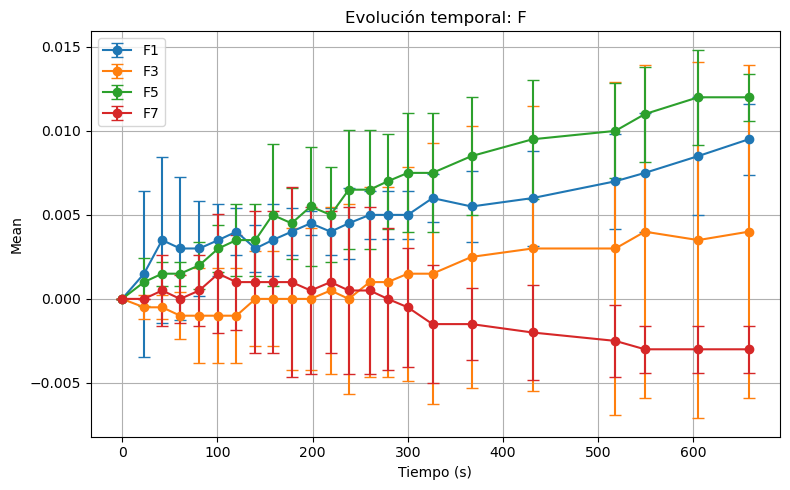

In [7]:
plot_letra(tablas[2], "E")
plot_letra(tablas[2], "F")


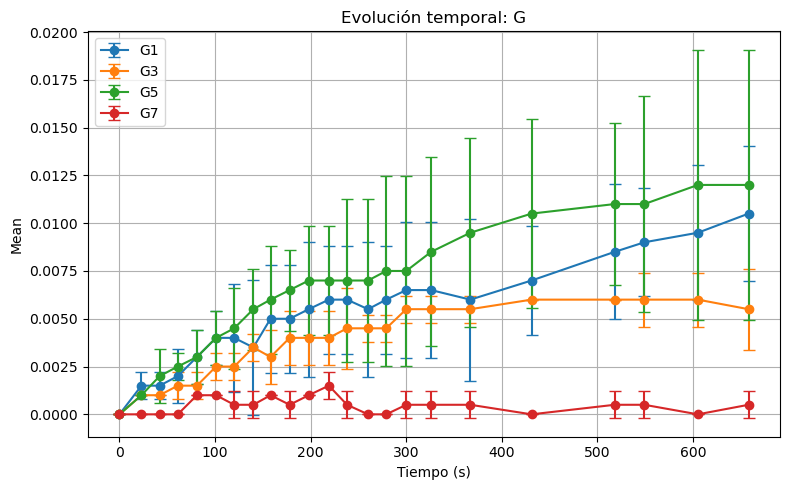

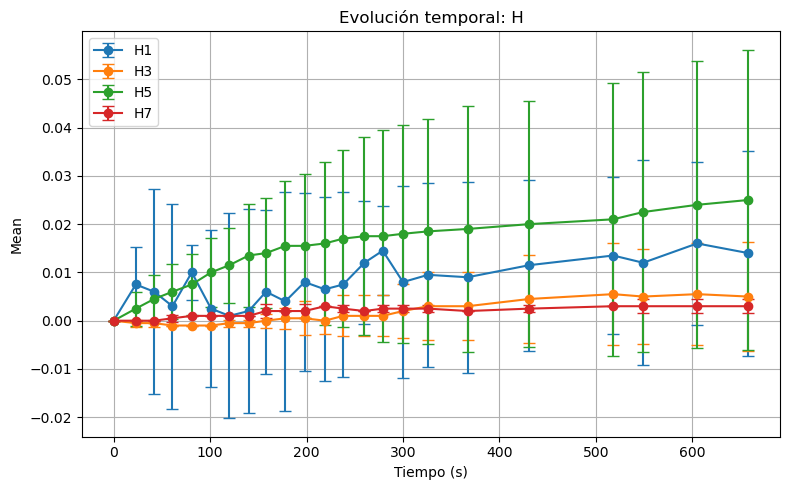

In [8]:
plot_letra(tablas[3], "G")
plot_letra(tablas[3], "H")


In [9]:
def plot_variable(tabla, mean_col, err_col=None):
    """
    Grafica una variable cualquiera (incluyendo blancos).
    mean_col: nombre exacto de la columna
    err_col: nombre exacto de la columna de error (opcional)
    """
    tiempos = tabla["Tiempo"]

    plt.figure(figsize=(8,5))

    if err_col is not None and err_col in tabla.columns:
        plt.errorbar(
            tiempos,
            tabla[mean_col],
            yerr=tabla[err_col],
            fmt='o-',
            capsize=4
        )
    else:
        plt.plot(tiempos, tabla[mean_col], 'o-')

    plt.xlabel("Tiempo (s)")
    plt.ylabel(mean_col)
    plt.title(f"Evolución temporal: {mean_col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


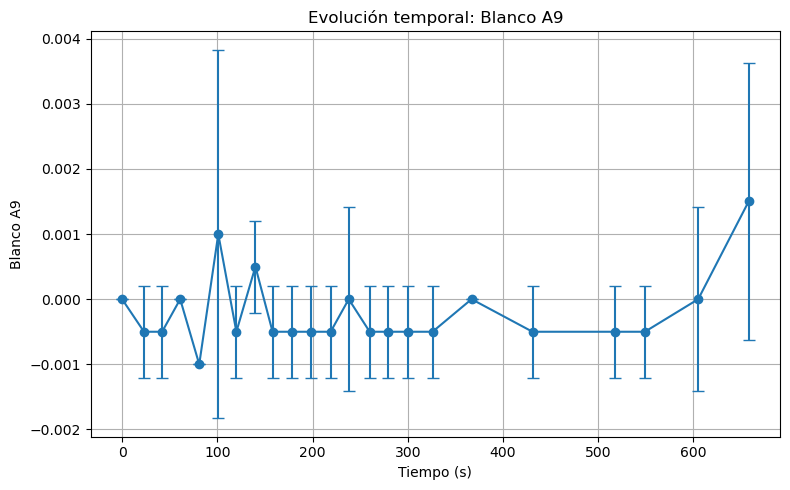

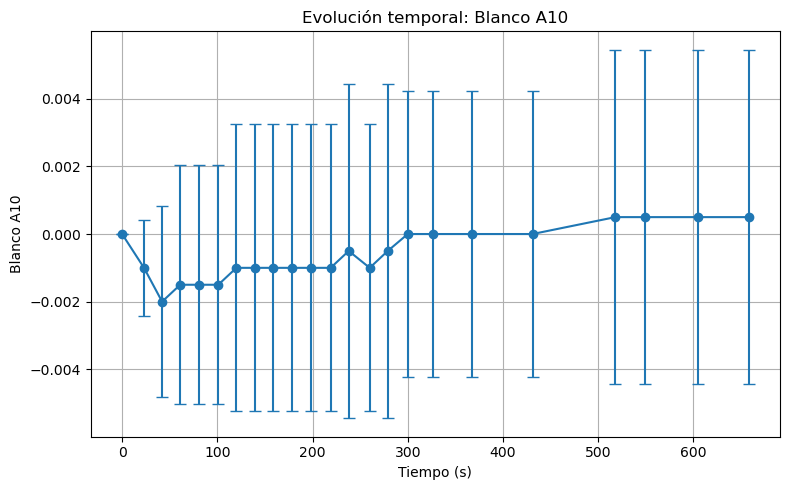

In [10]:
plot_variable(tablas[0], "Blanco A9", "errA9")
plot_variable(tablas[0], "Blanco A10", "errA10")


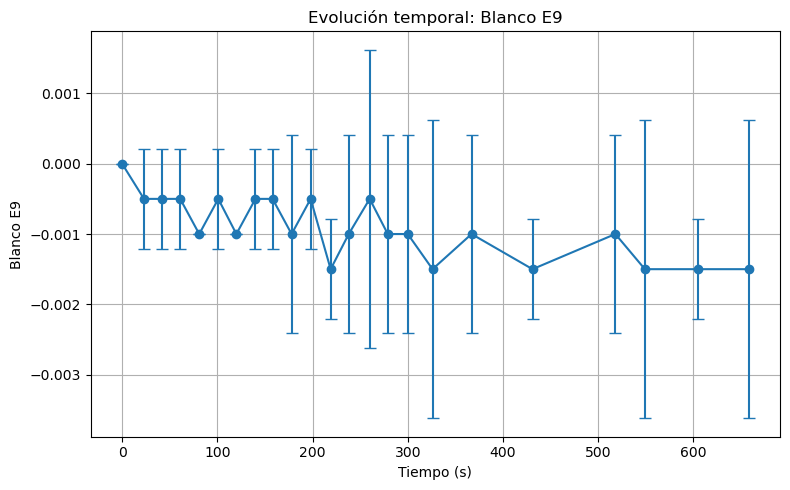

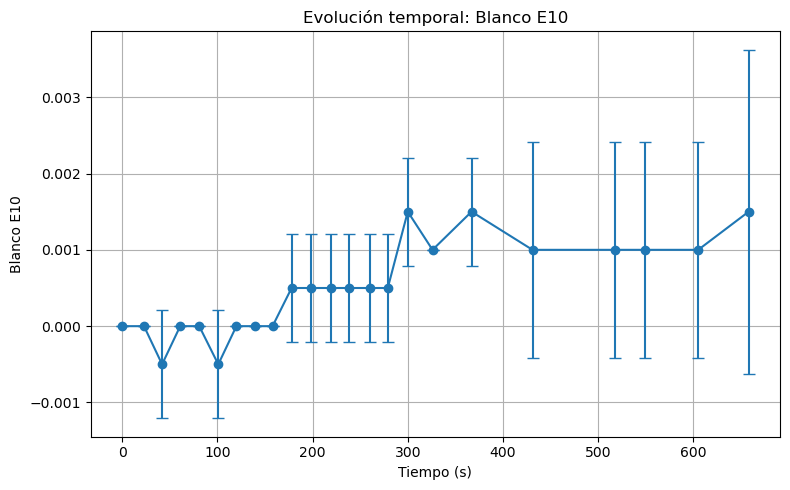

In [11]:
plot_variable(tablas[2], "Blanco E9", "errE9")
plot_variable(tablas[2], "Blanco E10", "errE10")

# Buen ajuste

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grupo(tablas, letras, index, nombre, t_min=None, t_max=None, ajustar=False):
    """
    tablas: lista de dataframes [AB, CD, EF, GH]
    letras: lista de letras a graficar, ej: ["A","B","C","D"]
    index : número (1, 3, 5, 7...)
    t_min, t_max : límites para el ajuste lineal
    ajustar: True para ajustar y calcular actividad
    """
    resultados = []   # <-- para guardar actividades y errores

    plt.figure(figsize=(8,5))

    for letra in letras:
        # seleccionar tabla
        if letra in ["A","B"]:
            t = tablas[0]
        elif letra in ["C","D"]:
            t = tablas[1]
        elif letra in ["E","F"]:
            t = tablas[2]
        elif letra in ["G","H"]:
            t = tablas[3]

        mean_col = f"{letra}{index}"
        err_col  = f"err{letra}{index}"

        if mean_col in t.columns:

            tiempo = t["Tiempo"].values
            y = t[mean_col].values
            yerr = t[err_col].values

            # Graficar valores con su color
            eb = plt.errorbar(
                tiempo, y, yerr=yerr,
                fmt='o-', capsize=4,
                label=mean_col
            )
            color = eb[0].get_color()

            # ============================================================
            #     AJUSTE LINEAL CON CÁLCULO DEL ERROR DE LA PENDIENTE
            # ============================================================
            if ajustar:
                mask = np.ones(len(tiempo), dtype=bool)
                if t_min is not None: mask &= tiempo >= t_min
                if t_max is not None: mask &= tiempo <= t_max

                t_fit = tiempo[mask]
                y_fit = y[mask]

                if len(t_fit) >= 2:

                    # Matriz para regresión lineal
                    A = np.vstack([t_fit, np.ones(len(t_fit))]).T
                    m, b = np.linalg.lstsq(A, y_fit, rcond=None)[0]

                    # --- Calcular error de la pendiente ---
                    y_pred = m * t_fit + b
                    residuals = y_fit - y_pred
                    N = len(t_fit)

                    # Varianza residual
                    s2 = np.sum(residuals**2) / (N - 2)

                    # sum((t - tbar)^2)
                    Sxx = np.sum((t_fit - np.mean(t_fit))**2)

                    # error estándar de m
                    m_err = np.sqrt(s2 / Sxx)

                    # --- Actividad ---
                    factor = 200 / (9.46 * 3680)
                    actividad = m * factor
                    actividad_err = m_err * factor

                    # Graficar línea ajustada
                    x_line = np.linspace(t_fit.min(), t_fit.max(), 200)
                    y_line = m * x_line + b

                    plt.plot(
                        x_line, y_line, '--',
                        color=color,
                        label=f"Ajuste {letra}{index} (Φ={actividad:.2e}(M.μl/s))"
                    )

                    # --- Mostrar resultados ---
                    print(f"\n=== {letra}{index} ===")
                    print(f"Pendiente m       = {m:.6e} ± {m_err:.6e}")
                    print(f"Actividad         = {actividad:.6e} ± {actividad_err:.6e}")
                    print(f"Rango usado       = {t_fit.min()} – {t_fit.max()} s\n")

                    # Guardar para posible exportación
                    resultados.append({
                        "Letra": letra,
                        "Index": index,
                        "Pendiente": m,
                        "Err_Pendiente": m_err,
                        "Actividad": actividad,
                        "Err_Actividad": actividad_err
                    })

                else:
                    print(f"No hay suficientes puntos para ajustar {letra}{index}")

    plt.xlabel("Tiempo (s)")
    plt.ylabel("Absorbancia")
    plt.title(nombre)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return resultados


In [18]:
resultados=[]


=== A1 ===
Pendiente m       = 2.292418e-05 ± 4.967050e-06
Actividad         = 1.316997e-07 ± 2.853577e-08
Rango usado       = 61 – 198 s


=== B1 ===
Pendiente m       = 1.221418e-05 ± 3.237612e-06
Actividad         = 7.017065e-08 ± 1.860012e-08
Rango usado       = 61 – 198 s


=== C1 ===
Pendiente m       = 2.816724e-05 ± 1.979207e-06
Actividad         = 1.618212e-07 ± 1.137057e-08
Rango usado       = 61 – 198 s


=== D1 ===
Pendiente m       = 3.699209e-05 ± 5.550798e-06
Actividad         = 2.125201e-07 ± 3.188941e-08
Rango usado       = 61 – 198 s



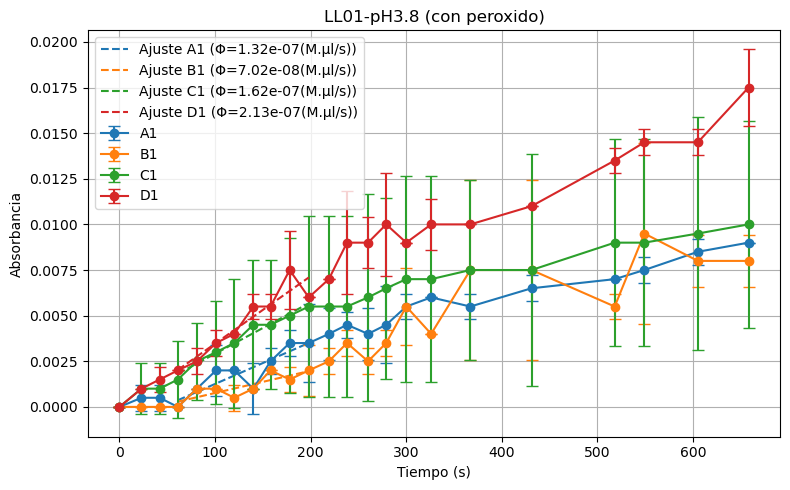

In [19]:
resultados.append(plot_grupo(
    tablas, 
    letras=["A","B","C","D"], 
    index=1,
    nombre="LL01-pH3.8 (con peroxido)",
    t_min=50,
    t_max=200,
    ajustar=True
))



=== E1 ===
Pendiente m       = 8.648114e-06 ± 8.971246e-06
Actividad         = 4.968353e-08 ± 5.153993e-08
Rango usado       = 61 – 198 s


=== F1 ===
Pendiente m       = 8.871975e-06 ± 3.180944e-06
Actividad         = 5.096961e-08 ± 1.827456e-08
Rango usado       = 61 – 198 s


=== G1 ===
Pendiente m       = 2.262177e-05 ± 3.768707e-06
Actividad         = 1.299624e-07 ± 2.165127e-08
Rango usado       = 61 – 198 s


=== H1 ===
Pendiente m       = 9.940225e-06 ± 2.671515e-05
Actividad         = 5.710673e-08 ± 1.534789e-07
Rango usado       = 61 – 198 s



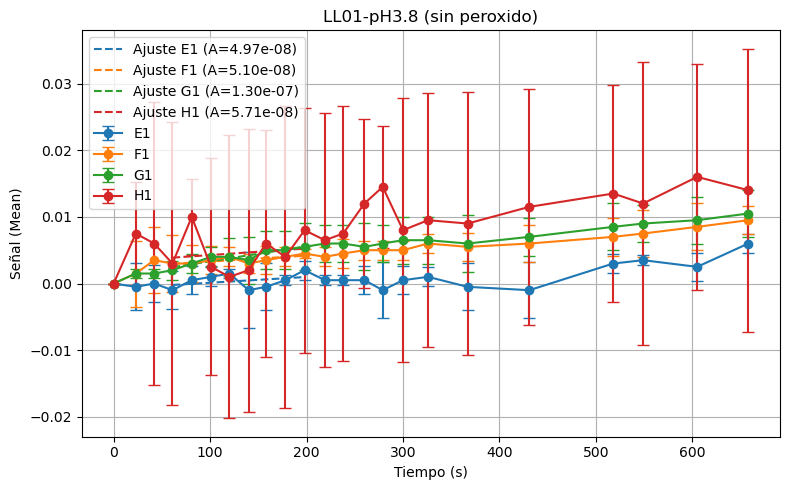

In [43]:
resultados.append(plot_grupo(
    tablas, 
    letras=["E","F","G","H"], 
    index=1,
    nombre="LL01-pH3.8 (sin peroxido)",
    t_min=50,
    t_max=200,
    ajustar=True
))




=== A3 ===
Pendiente m       = 2.122362e-05 ± 2.363356e-05
Actividad         = 1.219300e-07 ± 1.357751e-07
Rango usado       = 61 – 198 s


=== B3 ===
Pendiente m       = 9.398245e-06 ± 6.108744e-06
Actividad         = 5.399304e-08 ± 3.509482e-08
Rango usado       = 61 – 198 s


=== C3 ===
Pendiente m       = -6.150293e-06 ± 1.691023e-06
Actividad         = -3.533352e-08 ± 9.714951e-09
Rango usado       = 61 – 198 s


=== D3 ===
Pendiente m       = -2.163992e-06 ± 2.031935e-06
Actividad         = -1.243216e-08 ± 1.167350e-08
Rango usado       = 61 – 198 s



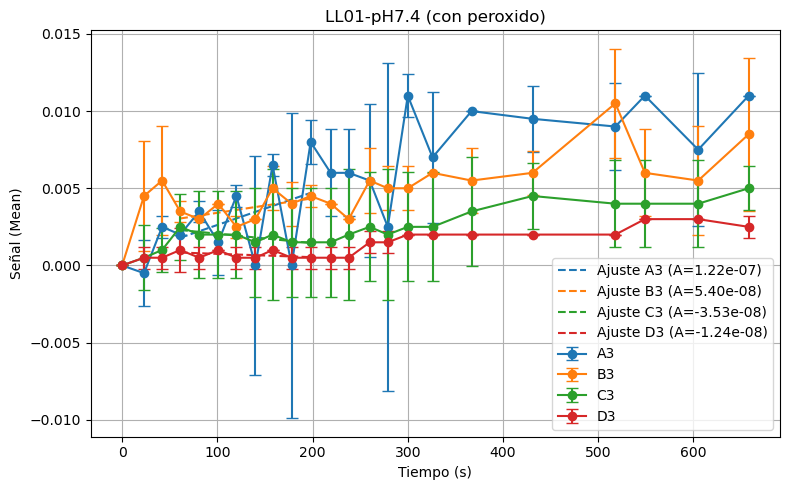

In [44]:
resultados.append(plot_grupo(
    tablas, 
    letras=["A","B","C","D"], 
    index=3,
    nombre="LL01-pH7.4 (con peroxido)",
    t_min=50,
    t_max=200,
    ajustar=True
)
)


=== E3 ===
Pendiente m       = 2.048134e-05 ± 1.752080e-06
Actividad         = 1.176656e-07 ± 1.006572e-08
Rango usado       = 61 – 198 s


=== F3 ===
Pendiente m       = 9.771347e-06 ± 2.243408e-06
Actividad         = 5.613652e-08 ± 1.288841e-08
Rango usado       = 61 – 198 s


=== G3 ===
Pendiente m       = 1.991580e-05 ± 2.622501e-06
Actividad         = 1.144165e-07 ± 1.506630e-08
Rango usado       = 61 – 198 s


=== H3 ===
Pendiente m       = 1.281115e-05 ± 1.660043e-06
Actividad         = 7.360021e-08 ± 9.536970e-09
Rango usado       = 61 – 198 s



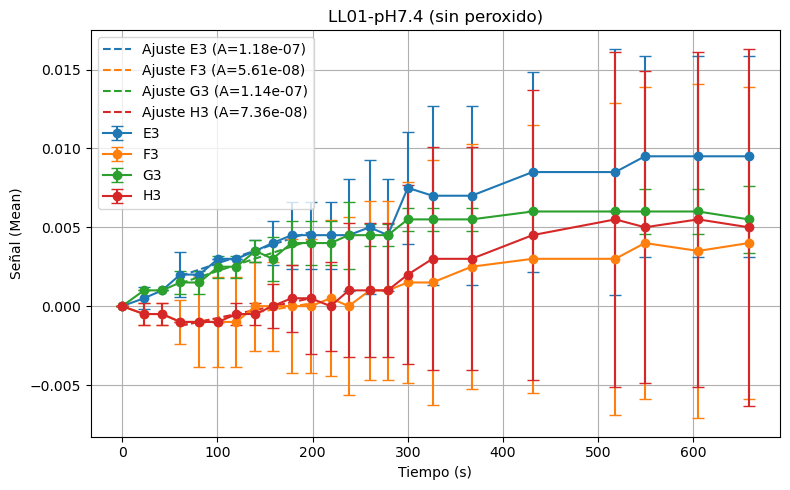

In [45]:
resultados.append(plot_grupo(
    tablas, 
    letras=["E","F","G","H"], 
    index=3,
    nombre="LL01-pH7.4 (sin peroxido)",
    t_min=50,
    t_max=200,
    ajustar=True
)
)


=== A5 ===
Pendiente m       = 4.096268e-05 ± 1.343910e-06
Actividad         = 2.353312e-07 ± 7.720780e-09
Rango usado       = 61 – 198 s


=== B5 ===
Pendiente m       = 1.648718e-05 ± 2.398235e-06
Actividad         = 9.471910e-08 ± 1.377789e-08
Rango usado       = 61 – 198 s


=== C5 ===
Pendiente m       = 1.222989e-05 ± 2.276315e-06
Actividad         = 7.026090e-08 ± 1.307746e-08
Rango usado       = 61 – 198 s


=== D5 ===
Pendiente m       = 4.038928e-05 ± 2.377651e-06
Actividad         = 2.320370e-07 ± 1.365964e-08
Rango usado       = 61 – 198 s



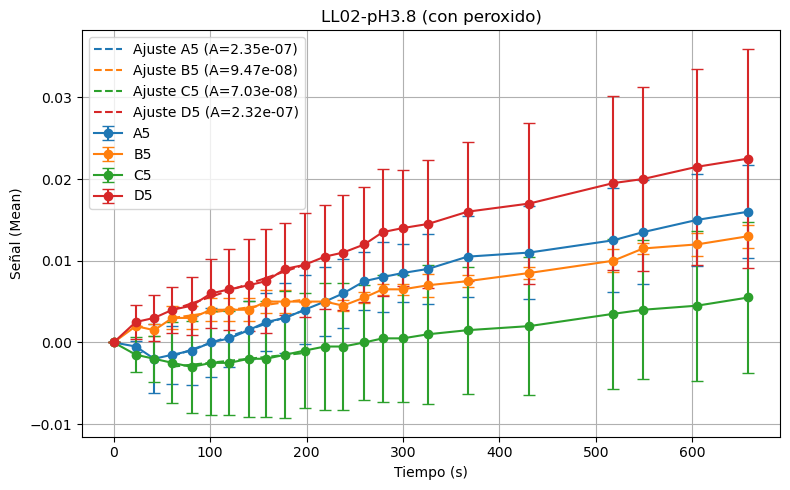

In [46]:
resultados.append(plot_grupo(
    tablas, 
    letras=["A","B","C","D"], 
    index=5,
    nombre="LL02-pH3.8 (con peroxido)",
    t_min=50,
    t_max=200,
    ajustar=True
)
)


=== E5 ===
Pendiente m       = 5.778370e-05 ± 1.867578e-06
Actividad         = 3.319681e-07 ± 1.072926e-08
Rango usado       = 61 – 198 s


=== F5 ===
Pendiente m       = 2.841467e-05 ± 3.018519e-06
Actividad         = 1.632427e-07 ± 1.734143e-08
Rango usado       = 61 – 198 s


=== G5 ===
Pendiente m       = 3.425470e-05 ± 1.454160e-06
Actividad         = 1.967937e-07 ± 8.354170e-09
Rango usado       = 61 – 198 s


=== H5 ===
Pendiente m       = 7.374461e-05 ± 6.411320e-06
Actividad         = 4.236638e-07 ± 3.683312e-08
Rango usado       = 61 – 198 s



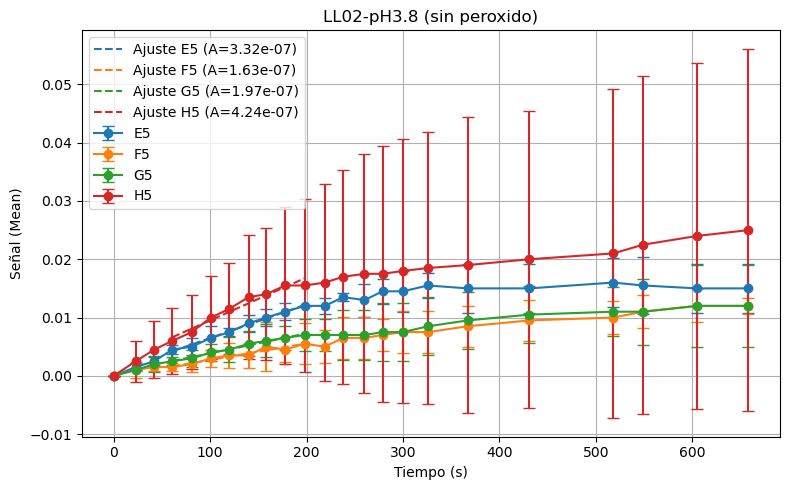

In [47]:
resultados.append(plot_grupo(
    tablas, 
    letras=["E","F","G","H"], 
    index=5,
    nombre="LL02-pH3.8 (sin peroxido)",
    t_min=50,
    t_max=200,
    ajustar=True
)
)


=== A7 ===
Pendiente m       = 1.805127e-05 ± 4.649177e-06
Actividad         = 1.037048e-07 ± 2.670958e-08
Rango usado       = 23 – 81 s


=== B7 ===
Pendiente m       = 4.133673e-05 ± 9.225424e-06
Actividad         = 2.374801e-07 ± 5.300018e-08
Rango usado       = 23 – 81 s


=== C7 ===
Pendiente m       = -7.851295e-06 ± 4.416718e-06
Actividad         = -4.510580e-08 ± 2.537410e-08
Rango usado       = 23 – 81 s


=== D7 ===
Pendiente m       = 1.529996e-05 ± 1.689929e-05
Actividad         = 8.789847e-08 ± 9.708667e-08
Rango usado       = 23 – 81 s



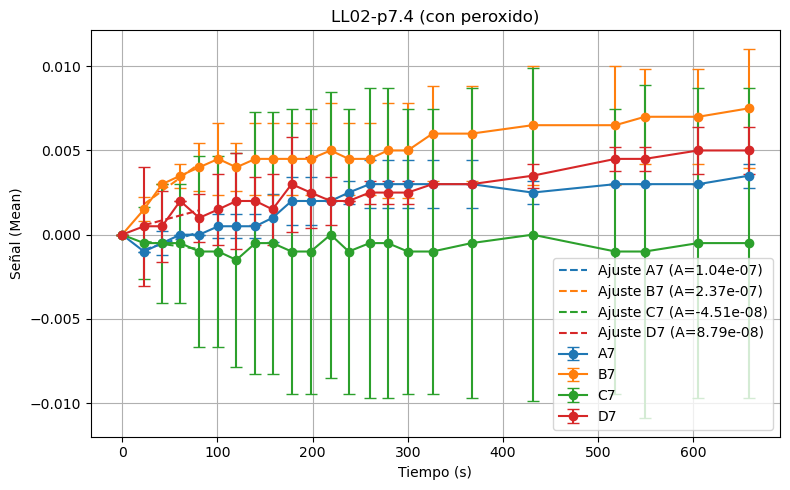

In [48]:
resultados.append(plot_grupo(
    tablas, 
    letras=["A","B","C","D"], 
    index=7,
    nombre="LL02-p7.4 (con peroxido)",
    t_min=10,
    t_max=100,
    ajustar=True
)
)


=== E7 ===
Pendiente m       = 1.295128e-05 ± 1.003350e-05
Actividad         = 7.440529e-08 ± 5.764260e-08
Rango usado       = 23 – 81 s


=== F7 ===
Pendiente m       = 5.234197e-06 ± 7.307987e-06
Actividad         = 3.007053e-08 ± 4.198448e-08
Rango usado       = 23 – 81 s


=== G7 ===
Pendiente m       = 1.570259e-05 ± 8.833436e-06
Actividad         = 9.021159e-08 ± 5.074821e-08
Rango usado       = 23 – 81 s


=== H7 ===
Pendiente m       = 1.818548e-05 ± 4.379860e-06
Actividad         = 1.044758e-07 ± 2.516235e-08
Rango usado       = 23 – 81 s



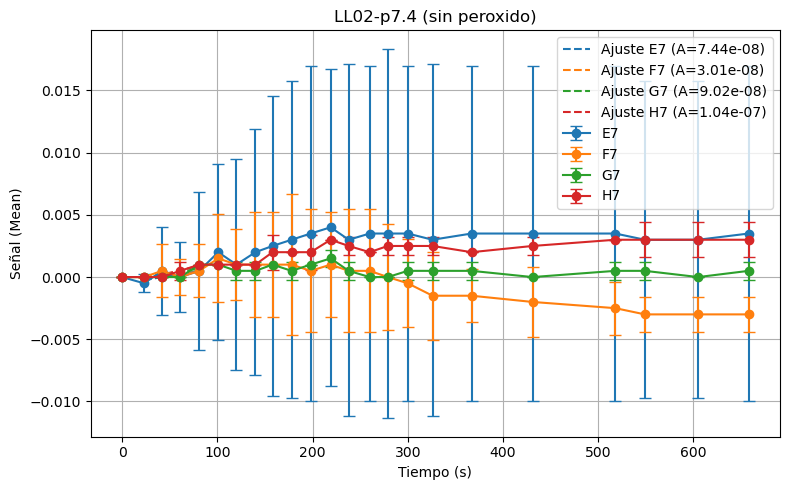

In [49]:
resultados.append(plot_grupo(
    tablas, 
    letras=["E","F","G","H"], 
    index=7,
    nombre="LL02-p7.4 (sin peroxido)",
    t_min=10,
    t_max=100,
    ajustar=True
)
)

# Actividad

In [58]:
import matplotlib.pyplot as plt
import numpy as np

def graficar_por_grupo(resultados, grupo_idx, nombre_grupo, titulo):
    """
    resultados: tu lista completa
    grupo_idx: 0..7 (pares = AB-CD, impares = EF-GH)
    nombre_grupo: texto para el título
    """

    grupo = resultados[grupo_idx]

    # volumen asociado a cada letra
    volumen = {"A":5, "B":10, "C":15, "D":20,
               "E":5, "F":10, "G":15, "H":20}

    # Construir arrays
    x = []
    y = []
    yerr = []

    for r in grupo:
        letra = r["Letra"]
        x.append(volumen[letra])
        y.append(r["Actividad"])
        yerr.append(r["Err_Actividad"])

    # ordenar por volumen
    x = np.array(x)
    y = np.array(y)
    yerr = np.array(yerr)
    orden = np.argsort(x)

    x = x[orden]
    y = y[orden]
    yerr = yerr[orden]

    # graficar
    plt.figure(figsize=(7,5))
    plt.errorbar(x, y, yerr=yerr, fmt='o-', capsize=5)
    plt.xlabel("Volumen de nanopartículas (µL)")
    plt.ylabel("Actividad")
    plt.title(f"{titulo}")
    plt.grid()
    plt.tight_layout()
    plt.show()


In [59]:
def graficar_todos(resultados):
    nombres = [
        "A1–D1", "E1–H1",
        "A3–D3", "E3–H3",
        "A5–D5", "E5–H5",
        "A7–D7", "E7–H7"
    ]
    labels=[
        "LL01-p3.8 (con peroxido)", "LL01-p3.8 (sin peroxido)",
        "LL01-p7.4 (con peroxido)", "LL01-p7.4 (sin peroxido)",
        "LL02-p3.8 (con peroxido)", "LL02-p3.8 (sin peroxido)",
        "LL02-p7.4 (con peroxido)", "LL02-p7.4 (sin peroxido)"
    ]

    for i in range(8):
        graficar_por_grupo(resultados, i, nombres[i],labels[i])


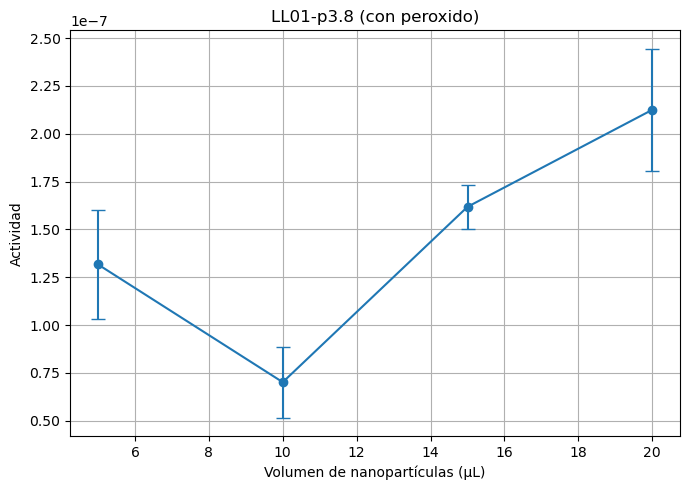

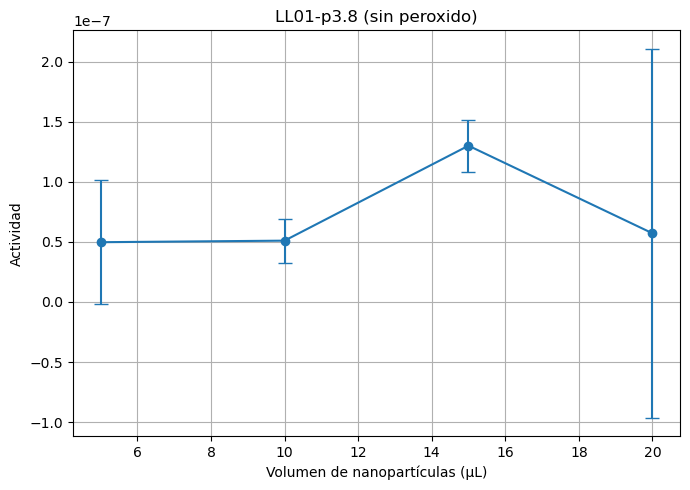

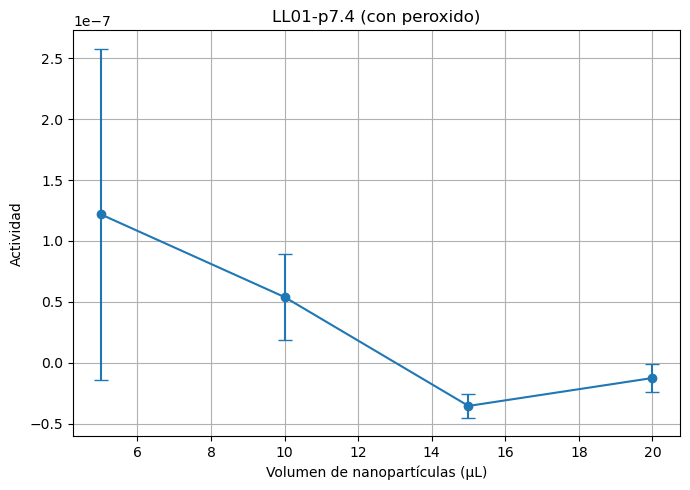

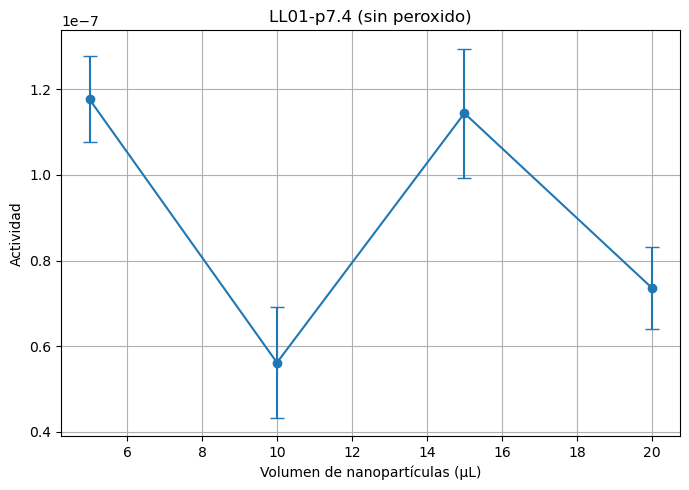

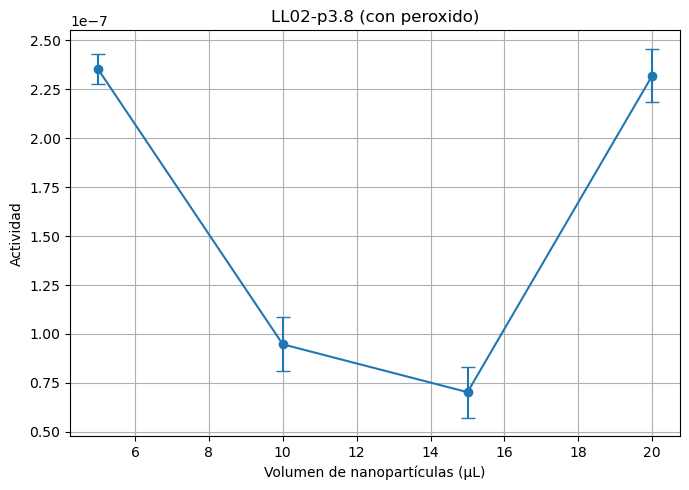

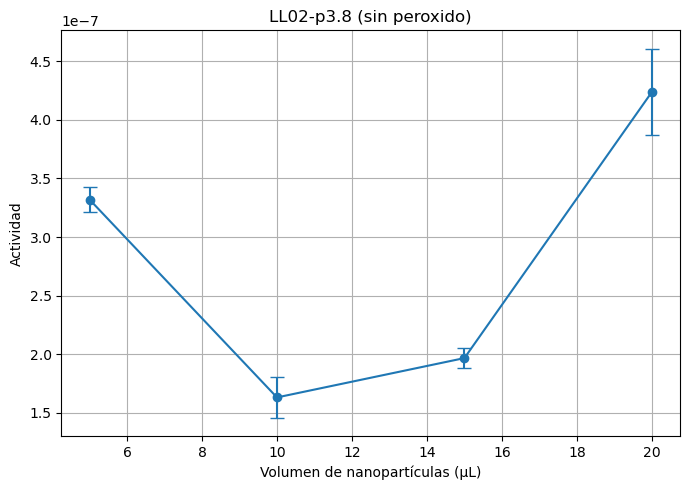

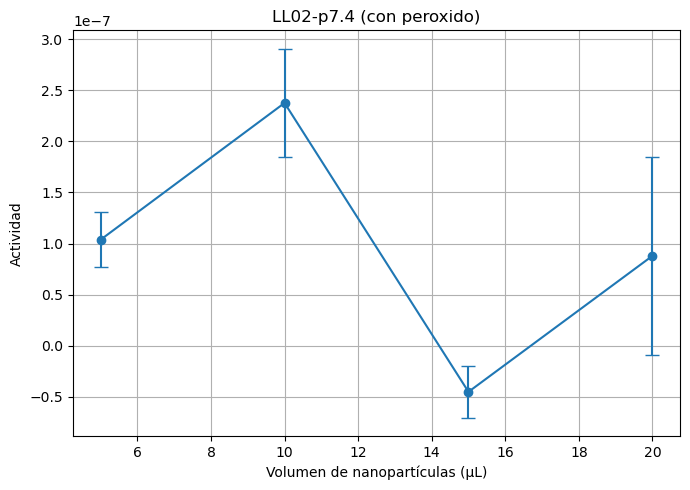

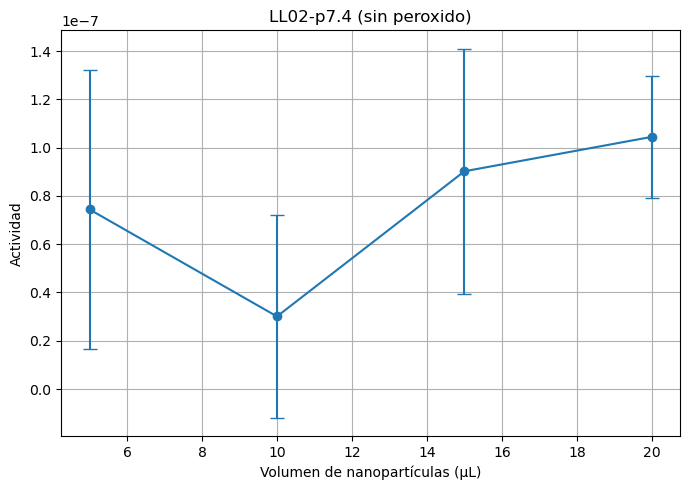

In [60]:
graficar_todos(resultados)
